In [1]:
# Import some dependencies
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import pandas as pd

# GET target for the live dataset
url = 'https://serene-forest-99801.herokuapp.com/api/allData'

# Define variables to hold plotting info for the final graph
accuracy_yAxis = []
models_xAxis = []

In [2]:
# Set up vectorizers to transform data
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

vectorizer = CountVectorizer()
tfidf = TfidfTransformer()

In [15]:
# Import the live dataset
dataset = pd.read_json(url)

print(dataset.race, dataset.writing)

0      American_Indian
1        Alaska_Native
2                Asian
3                Black
4                White
5                White
6                White
7                White
8                White
9                White
10               White
11               Mixed
12               White
13               White
14               White
15               White
16         unspecified
17         unspecified
18         unspecified
19         unspecified
20               Black
21               Asian
22               Black
23               White
24               White
25               White
26               Black
27               White
28               Asian
29            Filipino
            ...       
59               White
60      Middle_Eastern
61               Black
62               Black
63               Black
64               Black
65               White
66               Asian
67               Black
68               White
69         unspecified
70    Pacific_Islander
71    Pacif

In [16]:
# An attempt to massage the dataset to produce better results
# * Needed to bucket categories so each had 10+ features

# Regex for everything not in a defined bucket
regex = '^((?!(^White$)).).+$'

# Removes 'unspecified' since they are unknowable features
# and buckets all others into 'White' or 'PoC'
# for model evaluation
dataset = dataset[dataset.race != 'unspecified']
dataset['race'] = dataset['race'].replace(
    to_replace=regex,
    value='PoC',
    regex=True
)

print(dataset.race, dataset.writing)

0       PoC
1       PoC
2       PoC
3       PoC
4     White
5     White
6     White
7     White
8     White
9     White
10    White
11      PoC
12    White
13    White
14    White
15    White
20      PoC
21      PoC
22      PoC
23    White
24    White
25    White
26      PoC
27    White
28      PoC
29      PoC
30    White
31    White
32      PoC
33    White
      ...  
58    White
59    White
60      PoC
61      PoC
62      PoC
63      PoC
64      PoC
65    White
66      PoC
67      PoC
68    White
70      PoC
71      PoC
72      PoC
73    White
74      PoC
75    White
76    White
77    White
78      PoC
79    White
80    White
81    White
82    White
83    White
84    White
85      PoC
86    White
87    White
88    White
Name: race, Length: 82, dtype: object 0     For those of you folks who do not know who Jos...
1     Pre-contact, I’ve been told a lot that there w...
2     I have a dog and I love my dog. Television is ...
3     I lacked the enthusiasm my then-boyfriend of t...
4     

In [5]:
# Vectorize the data as needed and split into `X` and `y` varibles for training / testing
X = tfidf.fit_transform(vectorizer.fit_transform(dataset.writing))

y = dataset.race

In [6]:
# Test Multinomial Naive Bayes with K-Fold (10-fold) cross-validation
from sklearn.naive_bayes import MultinomialNB
multiNB = MultinomialNB()
accuracy_yAxis.append(cross_val_score(multiNB, X, y, cv=10, scoring='accuracy').mean())
models_xAxis.append('MultinomialNB')

In [7]:
# Test Bernoulli Naive Bayes with K-Fold (10-fold) cross-validation
from sklearn.naive_bayes import BernoulliNB
bernoulliNB = BernoulliNB()
accuracy_yAxis.append(cross_val_score(bernoulliNB, X, y, cv=10, scoring='accuracy').mean())
models_xAxis.append('BernoulliNB')
#print(cross_val_score(bernoulliNB, X, y, cv=10, scoring='accuracy').mean())

In [8]:
# Test Support Vector Machine with K-Fold (10-fold) cross-validation
from sklearn.linear_model import SGDClassifier
svm = SGDClassifier(loss='hinge', penalty='l2',
                   alpha=1e-3, n_iter=5,
                   random_state=1)
accuracy_yAxis.append(cross_val_score(svm, X, y, cv=10, scoring='accuracy').mean())
models_xAxis.append('SVM')

In [9]:
# Test Logistic Regression with K-Fold (10-fold) cross-validation
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
accuracy_yAxis.append(cross_val_score(logreg, X, y, cv=10, scoring='accuracy').mean())
models_xAxis.append('Logistic Regression')

In [10]:
# Test a range of KNN values with K-Fold (10-fold) cross-validation
# and pick out the optimal K value
from sklearn.neighbors import KNeighborsClassifier
k_range = range(1,31)
topscore = 0
topscoreIndex = 0
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y, cv=10, scoring='accuracy').mean()
    if score >= topscore:
        topscore = score
        topscoreIndex = k
accuracy_yAxis.append(topscore)
models_xAxis.append('KNN {0}'.format(topscoreIndex))

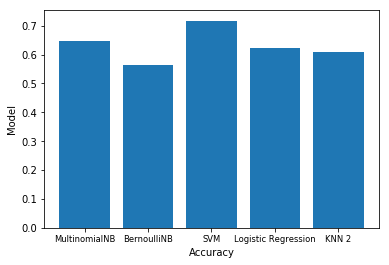

In [11]:
# Graph the accuracy of the tested models
import matplotlib.pyplot as plt
%matplotlib inline

plt.bar(range(len(models_xAxis)), accuracy_yAxis, align='center')
plt.xticks(range(len(models_xAxis)), models_xAxis, size='small')
plt.xlabel('Accuracy')
plt.ylabel('Model')